# Magic Squad - Seattle AirBnB Prices

The rental prices for listings on AirBnB vary greatly. Investigating and predicting the price of an AirBnB's rental would be beneficial in assisting the listers/owners how to price to potential renters and to the customers' looking to book a rental at the right cost.

## Problem Statement
Determine what factors contribute to the price of AirBnB listings in Seattle, WA and the solution is to have an understanding of the patterns and predictors of price.

In [1]:
import pandas as pd

import numpy as np

%matplotlib inline

import matplotlib.pyplot as plt

import seaborn as sns

# For Calculations
from math import floor

#For Modeling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression , Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor

# For Validation
from sklearn.metrics import mean_squared_error, accuracy_score

# For Storing Models
import pickle

# For Warnings
import warnings
warnings.filterwarnings("ignore")

Three data files are used for this project. The data files were aquired through Kaggle site

     1. listings.csv has Seattle AirBnB listing details
     2. calendar.csv has Seattle AirBnB listing availability by dates and prices
     3. Seattle_neighborhoods.csv has Seattle neighborhood data 

First we will load the data files

In [2]:
listings = pd.read_csv('listings.csv')
calendar = pd.read_csv('calendar.csv')
neighscore = pd.read_csv('Seattle_neighborhoods.csv')

Now take a look at column data to later do some clean up of the data

In [3]:
listings.info()
calendar.info()
neighscore.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3818 non-null   int64  
 1   listing_url                       3818 non-null   object 
 2   scrape_id                         3818 non-null   int64  
 3   last_scraped                      3818 non-null   object 
 4   name                              3818 non-null   object 
 5   summary                           3641 non-null   object 
 6   space                             3249 non-null   object 
 7   description                       3818 non-null   object 
 8   experiences_offered               3818 non-null   object 
 9   neighborhood_overview             2786 non-null   object 
 10  notes                             2212 non-null   object 
 11  transit                           2884 non-null   object 
 12  thumbn

### Data Cleaning:

    Unused columns will be dropped.
    Objects need to be converted to dates
    Prices need to be converted to float
    Handle missing/null values - modify or drop from data set

#### Data Cleaning listings data

In [4]:
# Data Cleaning listings
dropColumns = ['listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url',  'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time','review_scores_location',
       'host_response_rate', 'host_acceptance_rate', 'host_thumbnail_url', 'host_picture_url', 
       'host_neighbourhood','host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'square_feet','weekly_price', 'security_deposit', 'cleaning_fee',
       'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights',
       'calendar_updated', 'has_availability', 'availability_30',
       'availability_60', 'availability_90','calendar_last_scraped',  'first_review','monthly_price',
       'last_review', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin','review_scores_communication', 
       'review_scores_value', 'requires_license', 'license','jurisdiction_names', 
       'require_guest_profile_picture', 'require_guest_phone_verification',
       'calculated_host_listings_count', 'reviews_per_month']

listings = listings.drop(columns = dropColumns)

listings['price'] = listings['price'].apply(lambda x: x.replace('$',''))
listings['price'] = listings['price'].apply(lambda x: x.replace(',',''))
listings['price'] = listings['price'].astype(float)

listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            3818 non-null   int64  
 1   host_id                       3818 non-null   int64  
 2   host_is_superhost             3816 non-null   object 
 3   neighbourhood_cleansed        3818 non-null   object 
 4   neighbourhood_group_cleansed  3818 non-null   object 
 5   property_type                 3817 non-null   object 
 6   room_type                     3818 non-null   object 
 7   accommodates                  3818 non-null   int64  
 8   bathrooms                     3802 non-null   float64
 9   bedrooms                      3812 non-null   float64
 10  beds                          3817 non-null   float64
 11  bed_type                      3818 non-null   object 
 12  amenities                     3818 non-null   object 
 13  pri

These functions will show and handle missing values

In [5]:
def show_missing_values(listings):
    missing_vals = listings.isnull().sum().sort_values(ascending = False)
    
    return missing_vals.iloc[missing_vals.to_numpy().nonzero()[0]]

def handle_missing_remove(df):
    temp_df=df.copy()
    temp_df.beds.fillna(0,inplace=True)
    temp_df.bedrooms.fillna(0,inplace=True)
    temp_df.bathrooms.fillna(0,inplace=True)
    temp_df.host_is_superhost.fillna(0,inplace=True)
    temp_df.property_type.fillna(0,inplace=True)
     
    return temp_df

In [6]:
# Apply function to handle missing values to listings and check if any are remaining

listings=handle_missing_remove(listings)
show_missing_values(listings)

Series([], dtype: int64)

#### Data cleaning calendar data

In [7]:
calendar = calendar.drop(columns = ['available','listing_id'])
calendar = calendar.dropna()

calendar['date'] = pd.to_datetime(calendar['date'], format = '%Y-%m-%d')

calendar['price'] = calendar['price'].apply(lambda x: x.replace('$',''))
calendar['price'] = calendar['price'].apply(lambda x: x.replace(',',''))
calendar['price'] = calendar['price'].astype(float)

calendar.sort_values('date')

calendar.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 934542 entries, 0 to 1393213
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    934542 non-null  datetime64[ns]
 1   price   934542 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 21.4 MB


### Data Patterns and Visualization

Look through listings data for patterns

In [9]:
print(listings[['price']].describe())

print('\nAverage Price is $128. Price is between $20 to $1,000 per night')

             price
count  3818.000000
mean    127.976166
std      90.250022
min      20.000000
25%      75.000000
50%     100.000000
75%     150.000000
max    1000.000000

Average Price is $128. Price is between $20 to $1,000 per night


Text(0.5, 1.0, 'Price Density Listings')

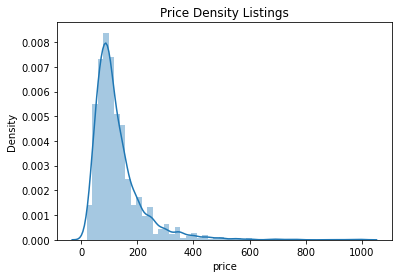

In [87]:
#Lets plot density of listing prices

sns.distplot(listings["price"])
plt.title("Price Density Listings")

    Majority of the listings are less than $100

In [16]:
#Price by Average Neighboorhood

ngPrice = listings.groupby('neighbourhood_group_cleansed')['price'].mean().sort_values(ascending = False)
ngPrice

neighbourhood_group_cleansed
Magnolia               177.672131
Queen Anne             157.223729
Downtown               154.405660
West Seattle           141.359606
Cascade                140.101124
Capitol Hill           130.592593
Central Area           128.338753
Ballard                124.682609
Other neighborhoods    119.968514
Interbay               109.727273
Seward Park            108.477273
Beacon Hill             94.669492
University District     93.639344
Lake City               92.671642
Rainier Valley          91.899371
Northgate               88.550000
Delridge                83.278481
Name: price, dtype: float64

    Magnolia has the highest average price, followed by Queen Anne and Downtown

Text(0.5, 1.0, 'Number of Listings in Seattle Neighbourhoods')

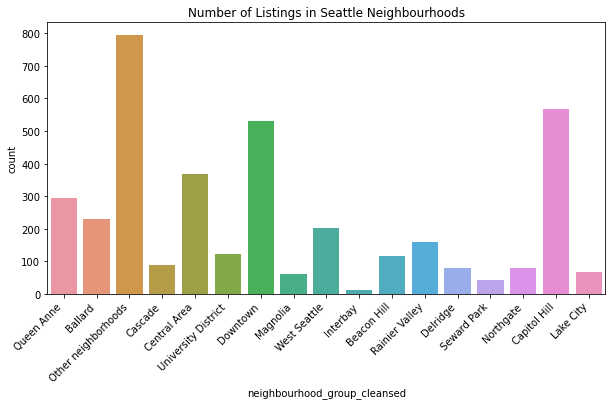

In [17]:
# Let's see how many listings are there per neighbourhood
plt.figure(figsize=(10,5))

chart = sns.countplot(listings['neighbourhood_group_cleansed'])

chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('Number of Listings in Seattle Neighbourhoods')

    Although Magnolia has highest average price, there are not many listings compared to other neighbourhoods
    Queen Anne has almost 300 listings and Downtown has over 500 listings

Text(0.5, 1.0, 'Availability by Neighbourhood')

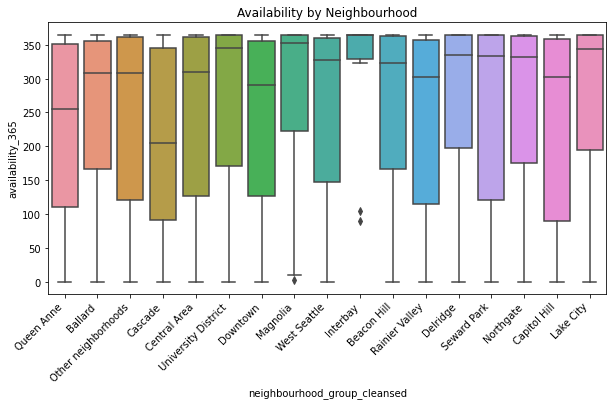

In [18]:
#Lets look at the availability through the year by neighbourhood using Boxplot
plt.figure(figsize=(10,5))

chart = sns.boxplot(x = listings['neighbourhood_group_cleansed'], y = listings['availability_365'])
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('Availability by Neighbourhood')

    Magnolia is largely available 3/4s of the year, with a listing outlier that has no availability

<AxesSubplot:>

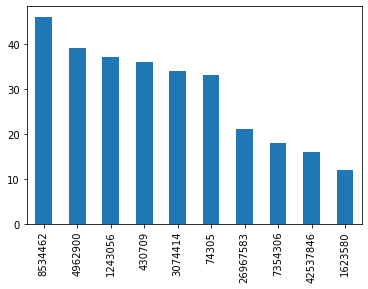

In [19]:
#Top 10 host with most listing
host_id_counts = listings["host_id"].value_counts().sort_values(ascending = False).nlargest(10)
host_id_counts
host_id_counts.T.plot(kind='bar')

Text(0.5, 1.0, 'Room Types')

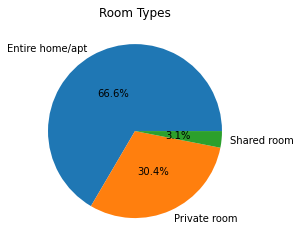

In [20]:
#Let's look at what room types are available

roomtypes = listings["room_type"].value_counts()
labels = roomtypes.keys()
plt.pie(x=roomtypes, autopct="%.1f%%", labels=labels, pctdistance=0.5)
plt.title("Room Types")

    Two thirds of the rooms available are entire home/apts

Now let's see how the listing prices are throughout the year in our calendar data

In [21]:
print('This data is for dates between',calendar['date'].min(),'and',calendar['date'].max())

This data is for dates between 2016-01-04 00:00:00 and 2017-01-02 00:00:00


In [22]:
#Take a look at avg price by month

calendar = calendar.groupby('date')['price'].mean().reset_index()
calendar = calendar.set_index('date')

y = calendar['price'].resample('MS').mean()
y['2016']


date
2016-01-01    121.692505
2016-02-01    124.315614
2016-03-01    128.640797
2016-04-01    135.109460
2016-05-01    139.539566
2016-06-01    147.469191
2016-07-01    152.102977
2016-08-01    150.657032
2016-09-01    143.277182
2016-10-01    137.033871
2016-11-01    135.687825
2016-12-01    137.238611
Freq: MS, Name: price, dtype: float64

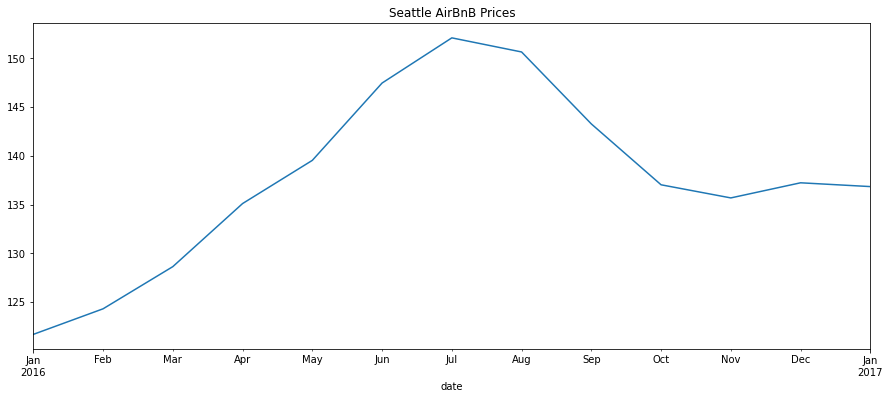

In [23]:
#Plot Avg Monthly Price
y.plot(figsize=(15,6))
plt.title('Seattle AirBnB Prices')
plt.show()

    Average Peak Month Prices for the Seattle Market is June - August

### Predictive Modeling of Price

    Create dummy columns for categorical data

In [24]:
#Create dummy columns for room_type, property_type, bed_type, and cancellation_policy
def create_dummies(listings, columns = ['room_type', 'property_type', 'bed_type', 'cancellation_policy']):
    for column in columns:
        dummies = pd.get_dummies(listings[column], prefix = column)
        listings = pd.concat([listings,dummies], axis = 1)
    return listings

listings = create_dummies(listings)
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 46 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             3818 non-null   int64  
 1   host_id                        3818 non-null   int64  
 2   host_is_superhost              3818 non-null   object 
 3   neighbourhood_cleansed         3818 non-null   object 
 4   neighbourhood_group_cleansed   3818 non-null   object 
 5   property_type                  3818 non-null   object 
 6   room_type                      3818 non-null   object 
 7   accommodates                   3818 non-null   int64  
 8   bathrooms                      3818 non-null   float64
 9   bedrooms                       3818 non-null   float64
 10  beds                           3818 non-null   float64
 11  bed_type                       3818 non-null   object 
 12  amenities                      3818 non-null   o

In [42]:
#Dummy columns for amenities as boolean

#Blank missing values
listings.loc[listings['amenities'] == '{}','amenities'] = ""
#Remove symbols and split with | as separator
listings['amenities'] = listings['amenities'].map(
    lambda amns: "|".join([amn.replace("}", "").replace("{", "").replace('"', "")\
                           for amn in amns.split(",")]))
#Get the unique of amenities
amenities = np.unique(np.concatenate(listings['amenities'].map(lambda amns: amns.split("|")).values))
#Map amenities to listings
amenities_matrix = np.array([listings['amenities'].map(lambda amns: amn in amns).values for amn in amenities])
#Create dataframe amenities with boolean values
amen=pd.DataFrame(data=amenities_matrix.T, columns=amenities)
#Concat the listing id to dataframe
listings_amenities = pd.concat([amen,listings['id']], axis=1)
#Remove first blank column
listings_amenities= listings_amenities.drop("",axis=1)

listings_amenities.head()

,24-Hour Check-in,Air Conditioning,Breakfast,Buzzer/Wireless Intercom,Cable TV,Carbon Monoxide Detector,Cat(s),Dog(s),Doorman,Dryer,...,Shampoo,Smoke Detector,Smoking Allowed,Suitable for Events,TV,Washer,Washer / Dryer,Wheelchair Accessible,Wireless Internet,id
0,False,True,False,False,True,False,False,False,False,True,...,False,False,False,False,True,True,False,False,True,241032
1,False,False,False,True,False,True,False,False,False,True,...,False,True,False,False,True,True,False,False,True,953595
2,False,True,False,False,True,True,True,True,False,True,...,True,True,False,False,True,True,False,False,True,3308979
3,False,False,False,False,False,True,False,False,False,True,...,True,True,False,False,False,True,False,False,True,7421966
4,False,False,False,False,True,True,False,False,False,False,...,True,True,False,False,True,False,False,False,True,278830


In [46]:
#Create dictionary to categorize amenities into groups
amenity_recode={
                'Air Conditioning':'Weather Control',
                'Indoor Fireplace':'Weather Control',
                'Heating':'Weather Control',
        
                'Carbon Monoxide Detector':'Safety Features',
                'Fire Extinguisher':'Safety Features',
                'First Aid Kit':'Safety Features',
                'Smoke Detector':'Safety Features',
                
                'Buzzer/Wireless Intercom':'Security Features',
                'Doorman':'Security Features',
                'Safety Card':'Security Features',
                'Lock on Bedroom Door':'Security Features',
                
                'Cat(s)':'Pet Friendly',
                'Dog(s)':'Pet Friendly',
                'Pets Allowed':'Pet Friendly',
                'Pets live on this property':'Pet Friendly',
                'Other pet(s)':'Pet Friendly',
                
                'Elevator in Building':'Access Friendly',
                'Wheelchair Accessible':'Access Friendly',
                
                'Essentials':'Essentials',
                'Hair Dryer':'Essentials',
                'Hangers':'Essentials',
                'Iron':'Essentials',
                'Shampoo':'Essentials',             
                
                'Cable TV':'TV',
                'TV':'TV',
                
                'Internet':'Internet',
                'Wireless Internet':'Internet',
                'Laptop Friendly Workspace':'Internet',
                
                'Dryer':'Laundry Facility',
                'Washer':'Laundry Facility',
                'Washer / Dryer':'Laundry Facility',
    
                #Remaining amenities which cannot be grouped
                #'Kitchen',
                #'Family/Kid Friendly', 
                #'Free Parking on Premises',
                #'Breakfast',
                #'24-Hour Check-in',
                #'Hot Tub',
                #'Pool',
                #'Gym',
                #'Smoking Allowed',
                #'Suitable for Events'
}

In [49]:
#Melt the amenities with dictionary and add column
#Melt the amenities dataframe and recode from the dictionary
listings_amenities_melt = listings_amenities.melt(id_vars=['id'], var_name='amenity')

#Recoding and putting in new column called amenity_modified
listings_amenities_melt = listings_amenities_melt.assign(
    amenity_modified = listings_amenities_melt.amenity.replace(amenity_recode))



In [50]:
listings_amenities_melt.head()

,id,amenity,value,amenity_modified
0,241032,24-Hour Check-in,False,24-Hour Check-in
1,953595,24-Hour Check-in,False,24-Hour Check-in
2,3308979,24-Hour Check-in,False,24-Hour Check-in
3,7421966,24-Hour Check-in,False,24-Hour Check-in
4,278830,24-Hour Check-in,False,24-Hour Check-in


In [52]:
#Pivot the melted dataframe and join with original dataframe
listings_amenities_pivot = listings_amenities_melt.pivot_table(
    index='id',
    columns='amenity_modified',
    values='value', 
    aggfunc='max')

listings_joined=listings.join(listings_amenities_pivot,on="id",how="inner")
listings_joined.head()

,id,host_id,host_is_superhost,neighbourhood_cleansed,neighbourhood_group_cleansed,property_type,room_type,accommodates,bathrooms,bedrooms,...,Kitchen,Laundry Facility,Pet Friendly,Pool,Safety Features,Security Features,Smoking Allowed,Suitable for Events,TV,Weather Control
0,241032,956883,f,West Queen Anne,Queen Anne,Apartment,Entire home/apt,4,1.0,1.0,...,True,True,False,False,False,False,False,False,True,True
1,953595,5177328,t,West Queen Anne,Queen Anne,Apartment,Entire home/apt,4,1.0,1.0,...,True,True,False,False,True,True,False,False,True,True
2,3308979,16708587,f,West Queen Anne,Queen Anne,House,Entire home/apt,11,4.5,5.0,...,True,True,True,False,True,False,False,False,True,True
3,7421966,9851441,f,West Queen Anne,Queen Anne,Apartment,Entire home/apt,3,1.0,0.0,...,True,True,False,False,True,True,False,False,False,True
4,278830,1452570,f,West Queen Anne,Queen Anne,House,Entire home/apt,6,2.0,3.0,...,True,False,False,False,True,False,False,False,True,True


In [53]:
#Join neighscore data to dataframe

listings_am_ns=pd.merge(neighscore, listings_joined, how='right', left_on=['name'], right_on=['neighbourhood_cleansed'])

#Drop unused columns
dcolumns = ['rank','name','population']
listings_am_ns = listings_am_ns.drop(columns = dcolumns)

listings_am_ns.head()

,walk_score,transit_score,bike_score,id,host_id,host_is_superhost,neighbourhood_cleansed,neighbourhood_group_cleansed,property_type,room_type,...,Kitchen,Laundry Facility,Pet Friendly,Pool,Safety Features,Security Features,Smoking Allowed,Suitable for Events,TV,Weather Control
0,83.0,61.0,61.0,241032,956883,f,West Queen Anne,Queen Anne,Apartment,Entire home/apt,...,True,True,False,False,False,False,False,False,True,True
1,83.0,61.0,61.0,953595,5177328,t,West Queen Anne,Queen Anne,Apartment,Entire home/apt,...,True,True,False,False,True,True,False,False,True,True
2,83.0,61.0,61.0,3308979,16708587,f,West Queen Anne,Queen Anne,House,Entire home/apt,...,True,True,True,False,True,False,False,False,True,True
3,83.0,61.0,61.0,7421966,9851441,f,West Queen Anne,Queen Anne,Apartment,Entire home/apt,...,True,True,False,False,True,True,False,False,False,True
4,83.0,61.0,61.0,278830,1452570,f,West Queen Anne,Queen Anne,House,Entire home/apt,...,True,False,False,False,True,False,False,False,True,True


In [54]:
#Function for handling missing values for new columns from neighscore
def handle_missing_remove_ns(df):
    temp_df=df.copy()
    temp_df.walk_score.fillna(0,inplace=True)
    temp_df.bike_score.fillna(0,inplace=True)
    temp_df.transit_score.fillna(0,inplace=True)
    return temp_df

listings_am_ns = handle_missing_remove_ns(listings_am_ns)
show_missing_values(listings_am_ns)

Series([], dtype: int64)

In [81]:
#Creating the train and validation data split
np.random.seed(2)
train = np.random.choice([True, False], listings_am_ns.shape[0], replace=True, p=[0.8, 0.2])
listings_train = listings_am_ns.iloc[train,:]
listings_test = listings_am_ns.iloc[~train,:]

listings_train.info()
listings_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3057 entries, 0 to 3817
Data columns (total 68 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   walk_score                     3057 non-null   float64
 1   transit_score                  3057 non-null   float64
 2   bike_score                     3057 non-null   float64
 3   id                             3057 non-null   int64  
 4   host_id                        3057 non-null   int64  
 5   host_is_superhost              3057 non-null   object 
 6   neighbourhood_cleansed         3057 non-null   object 
 7   neighbourhood_group_cleansed   3057 non-null   object 
 8   property_type                  3057 non-null   object 
 9   room_type                      3057 non-null   object 
 10  accommodates                   3057 non-null   int64  
 11  bathrooms                      3057 non-null   float64
 12  bedrooms                       3057 non-null   f

In [82]:
#Creating model function
def model_listing(regr,train_cols,target_col):
    
    x_train = listings_train[train_cols].values
    x_test = listings_test[train_cols].values
    y_train = listings_train[target_col].values
    y_test = listings_test[target_col].values
    
    print("Shape of Train and Test data")
    print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)
    print(" ------------------------------------------ ")
    
    rg = regr()

    # Fit the model on to the training data( Train the model )
    rg.fit(x_train, y_train)
    
    # Use the model to predict values
    y_pred = rg.predict(x_train)

    # Calculate the Mean Squared Error using the mean_squared_error function.
    print("Training Data")
    print("R^2 value using score fn: %.3f" % rg.score(x_train,y_train))
    print("Mean Squared Error : %0.3f" % mean_squared_error(y_train,y_pred))
    print("Root Mean Squared Error : %0.3f" % (mean_squared_error(y_train,y_pred))**0.5)
    print(" ------------------------------------------ ")
    # Use the model to predict values
    y_pred = rg.predict(x_test)

    # Calculate the Mean Squared Error using the mean_squared_error function.
    print("Test Data")
    print("R^2 value using score fn: %.3f" % rg.score(x_test,y_test))
    print("Mean Squared Error : %0.3f" % mean_squared_error(y_test,y_pred))
    print("Root Mean Squared Error : %0.3f" % (mean_squared_error(y_test,y_pred)**0.5))
    print(" ------------------------------------------ ")
    
    lin_reg_coef = pd.DataFrame(list(zip(train_cols,(rg.coef_))),columns=['Feature','Coefficient'])
    print(lin_reg_coef.sort_values(by='Coefficient',ascending=False))
    print(" ------------------------------------------ ")
    
    # Plot of model's residuals:
    fig = plt.figure(figsize=(10,3))

    sns.regplot(y_test,y_pred)
    plt.title("Residuals for the model")

Shape of Train and Test data
(3057, 31) (761, 31) (3057,) (761,)
 ------------------------------------------ 
Training Data
R^2 value using score fn: 0.538
Mean Squared Error : 3376.105
Root Mean Squared Error : 58.104
 ------------------------------------------ 
Test Data
R^2 value using score fn: 0.464
Mean Squared Error : 6152.554
Root Mean Squared Error : 78.438
 ------------------------------------------ 
                         Feature  Coefficient
6      room_type_Entire home/apt    68.711273
2                      bathrooms    36.030926
7         room_type_Private room    33.721521
0                   accommodates    15.606565
19                       Hot Tub    15.494887
13               Access Friendly    13.995261
18                           Gym     7.795424
29                            TV     6.696154
1                           beds     6.082570
28           Suitable for Events     5.177680
21                       Kitchen     3.739939
3              bed_type_Real Bed  

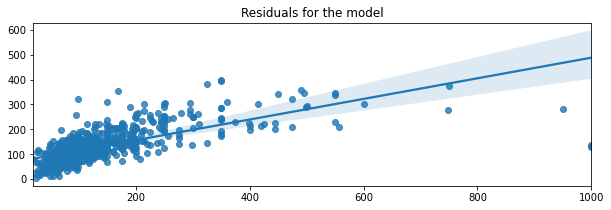

In [83]:
#Linear Regression - Basic + Score + Amenities

train_cols = [
    'accommodates', 
    'beds','bathrooms',
    'bed_type_Real Bed',
    'property_type_Condominium','property_type_Townhouse',
    'room_type_Entire home/apt', 'room_type_Private room',
    'property_type_Apartment','property_type_House', 
    'cancellation_policy_flexible', 'cancellation_policy_moderate',
    '24-Hour Check-in', 'Access Friendly', 'Breakfast', 'Essentials',
       'Family/Kid Friendly', 'Free Parking on Premises', 'Gym', 'Hot Tub',
       'Internet', 'Kitchen', 'Laundry Facility', 'Pet Friendly', 'Pool',
       'Safety Features', 'Security Features', 'Smoking Allowed',
       'Suitable for Events', 'TV', 'Weather Control','walk_score','transit_score','bike_score'
    
]

target_col = 'price'

model_listing(LinearRegression,train_cols,target_col)

(3057, 31) (761, 31) (3057,) (761,)


<AxesSubplot:xlabel='feature'>

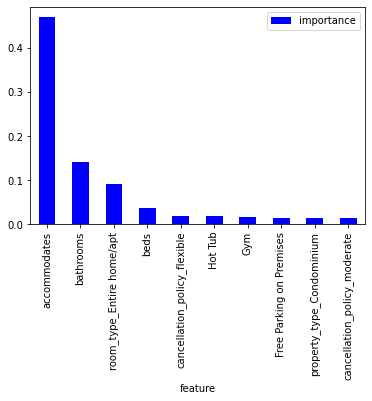

In [84]:
# Random Forest Model
train_cols = [
    'accommodates', 
    'beds','bathrooms',
    'bed_type_Real Bed',
    'property_type_Condominium','property_type_Townhouse',
    'room_type_Entire home/apt', 'room_type_Private room',
    'property_type_Apartment','property_type_House', 
    'cancellation_policy_flexible', 'cancellation_policy_moderate',
    '24-Hour Check-in', 'Access Friendly', 'Breakfast', 'Essentials',
       'Family/Kid Friendly', 'Free Parking on Premises', 'Gym', 'Hot Tub',
       'Internet', 'Kitchen', 'Laundry Facility', 'Pet Friendly', 'Pool',
       'Safety Features', 'Security Features', 'Smoking Allowed',
       'Suitable for Events', 'TV', 'Weather Control','walk_score','transit_score','bike_score'
    
]

target_col = 'price'

x_train = listings_train[train_cols].values
x_test = listings_test[train_cols].values
y_train = listings_train[target_col].values
y_test = listings_test[target_col].values

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

#Create a random forest regressor
clf = RandomForestRegressor(max_depth=10, n_estimators=100)

#Train the regressor
clf.fit(x_train, y_train)

#Plot variable importances for the top 10 predictors
importances = clf.feature_importances_
feat_names = train_cols
tree_result = pd.DataFrame({'feature': feat_names, 'importance': importances})
tree_result.sort_values(by='importance',ascending=False)[:10].plot(x='feature', y='importance', kind='bar',color='blue')

Training Data
R^2 value using score fn: 0.809
Mean Squared Error : 1394.751
Root Mean Squared Error : 37.346
 ------------------------------------------ 
Test Data
R^2 value using score fn: 0.472
Mean Squared Error : 6059.244
Root Mean Squared Error : 77.841
 ----------------------------------- 


Text(0.5, 1.0, 'Residuals for the model')

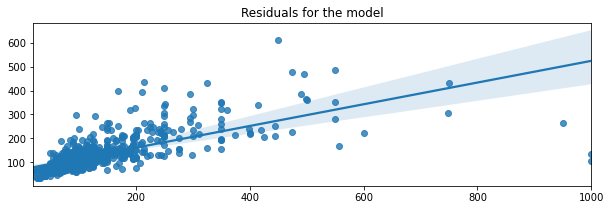

In [85]:
# Use the model to predict values
y_pred = clf.predict(x_train)

# Calculate the Mean Squared Error using the mean_squared_error function.
print("Training Data")
print("R^2 value using score fn: %.3f" % clf.score(x_train,y_train))
print("Mean Squared Error : %0.3f" % mean_squared_error(y_train,y_pred))
print("Root Mean Squared Error : %0.3f" % (mean_squared_error(y_train,y_pred))**0.5)


print(" ------------------------------------------ ")

# Use the model to predict values
y_pred = clf.predict(x_test)

# Calculate the Mean Squared Error using the mean_squared_error function.
print("Test Data")
print("R^2 value using score fn: %.3f" % clf.score(x_test,y_test))
print("Mean Squared Error : %0.3f" % mean_squared_error(y_test,y_pred))
print("Root Mean Squared Error : %0.3f" % (mean_squared_error(y_test,y_pred))**0.5)

print(" ----------------------------------- ")

# Plot of model's residuals:
fig = plt.figure(figsize=(10,3))

sns.regplot((y_test),(y_pred))
plt.title("Residuals for the model")

### Conclusions

##### Price Prediction

A linear regression model and random forest model was applied to the dataset to determine the predictors of price of an AirBnB rental in Seattle. The random forest model produced a better training model compared to the linear regression with a higher R-squared value. The highest predictor of price from the random forest model is how many people the room will accommodate, followed by the number of bathrooms. Please note that the random forest model training data accuracy is above 80%, yet the test data accuracy is 48%, possibly an overfitting of the model.




##### Property Owners
Regarding the price, an owner of the property can expect to see in the Seattle market to be quite competitive. Most properties in the Seattle market are priced at under $100 per night. A property in the Magnolia neighborhood can be priced slightly higher than other neighborhoods, since there are few listings. Additionally, if the rental can accommodate more guests it can translate to a higher rental price.


##### Customers
For a customer/renter looking at listings on AirBnB in the Seattle market, they can prepare for a better cost knowing when and what to book. Rentals during the summer months June through August are the highest. The Capital Hill neighborhood has the highest number of listings with a relatively competitive price. If the renter needs to accomodate a higher number of guests with them then they can expect to pay a higher price. Although 2/3's of the listings are for entire homes or apartments, renting a shared or private room could possibly be at a lower price.